In [47]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from xgboost import XGBRegressor
import math
import plotly.graph_objs as go
import chart_studio.plotly as py
from collections import defaultdict
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [48]:
def get_mae(a, b):
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

# 601390

## 1. Load Data

In [49]:
hkws_path = 'D:/DeskTop-Files/CUHK-SZ/2022-2023 Fall term/1-Wed-14~17-IBA6 Fintech and Application/Group_final/data_new5_withdiff_withlag/data_new5_withdiff_withlag/601390_stable.xlsx'
df = pd.DataFrame(pd.read_excel(hkws_path)) 
df.head()

,日期,收益率,ret_lag1,ret_lag2,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,前收盘价(元)_diff1,...,宏观_PPI_diff1,宏观_出口价格指数(总),宏观_出口价格指数(车船航),宏观_进口价格指数(总)_diff1,宏观_进口价格指数(车船航),宏观_固定资产投资完成额,宏观_社会消费品零售总额_diff1,宏观_M2_diff2,宏观_金融机构各项贷款余额_diff1,宏观_社会融资规模_diff1
0,2016-01-22,-0.006757,0.033760,-0.059146,-0.020386,0.100354,0.009535,-0.062570,0.015891,-2.557826,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
1,2016-01-25,-0.089569,-0.006757,0.033760,-0.059146,-0.020386,0.100354,0.009535,-0.062570,2.730887,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
2,2016-01-26,-0.017435,-0.089569,-0.006757,0.033760,-0.059146,-0.020386,0.100354,0.009535,-0.587521,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
3,2016-01-27,-0.082383,-0.017435,-0.089569,-0.006757,0.033760,-0.059146,-0.020386,0.100354,-2.557826,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
4,2016-01-28,0.099448,-0.082383,-0.017435,-0.089569,-0.006757,0.033760,-0.059146,-0.020386,-1.417123,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098


In [50]:
# hkws_path = 'D:/DeskTop-Files/CUHK-SZ/2022-2023 Fall term/1-Wed-14~17-IBA6 Fintech and Application/Group_final/data_new4_withdiff/data_new4_withdiff/海康威视_002415_成长.xlsx'
# df = pd.DataFrame(pd.read_excel(hkws_path)) 
# df.head()

In [51]:
index_val = df[df.日期 == '2021-01-04'].index[0]
index_test = df[df.日期 == '2022-01-04'].index[0]
print(index_val,index_test)

1204 1447


In [52]:
df.dropna(inplace=True)
df = df.drop(['日期'], axis=1)
y = df['收益率']
X = df.drop('收益率', axis=1) 

## 2. Split train set，validation set and test set 

In [53]:
X_train = X[0:index_val].copy()
X_val = X[index_val:index_test].copy()
X_test = X[index_test:].copy()
y_train = y[0:index_val].copy()
y_val = y[index_val:index_test].copy()
y_test = y[index_test:].copy()
print("X_train.shape = " + str(X_train.shape))
print("X_val.shape = " + str(X_val.shape))
print("X_test.shape = " + str(X_test.shape))

X_train.shape = (1204, 71)
X_val.shape = (243, 71)
X_test.shape = (221, 71)


## 3. Model cinstruction_XGBOOST

In [54]:
def xgb_model_train_val(X_train, y_train, X_val, y_val,
                          seed=100, n_estimators=100, max_depth=3, learning_rate=0.1,
                          min_child_weight=1, subsample=1, colsample_bytree=1, colsample_bylevel=1, gamma=0):

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=seed, n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mae, model

In [55]:
def model_test_eval(X_test, y_test, model):
    
    # Get predicted labels
    est = model.predict(X_test)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mae, est

### 1) Prediction before tuning on validation set

In [56]:
# Get error metrics on validation set before hyperparameter tuning
xgb_rmse_bef_tuning, xgb_mae_bef_tuning,xgb_model_bef_tuning = xgb_model_train_val(X_train, y_train, X_val, y_val)
                                                                
print("RMSE = %0.3f" % xgb_rmse_bef_tuning)
print("MAE = %0.3f" % xgb_mae_bef_tuning)

RMSE = 0.018
MAE = 0.012


### 2) Tuning parameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [57]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = [50,75,100,200]

param2_label = 'max_depth'
param2_list = [4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,
                                                            seed = 100,n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-57-256a1b781448>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/4 [00:00<?, ?it/s]

Minutes taken = 0.27


,n_estimators,max_depth,rmse,mae
0,50,4,0.017110,0.012091
1,50,5,0.017173,0.012021
2,50,6,0.017269,0.012537
3,50,7,0.017250,0.012537
4,50,8,0.017198,0.012676
5,50,9,0.017506,0.012843
6,75,4,0.017280,0.012034
7,75,5,0.017340,0.012120
8,75,6,0.017272,0.012294
9,75,7,0.017147,0.012270


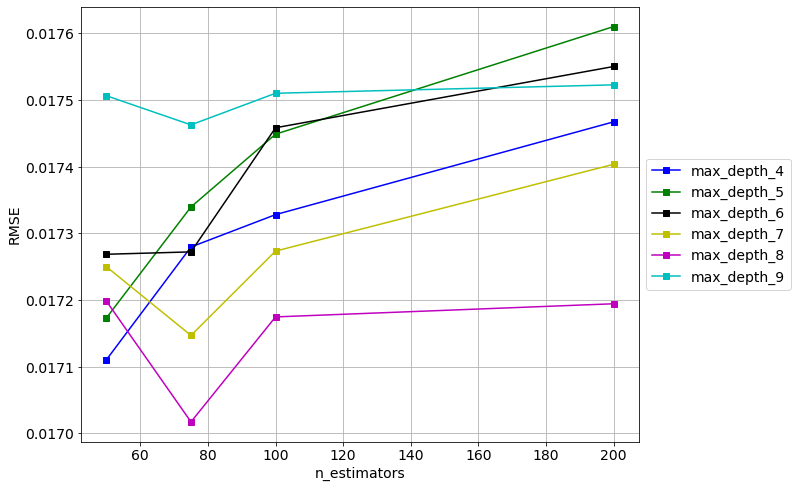

In [58]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [59]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.017
optimum params = 


(75, 8)

#### Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [60]:
param_label = 'learning_rate'
param_list = [ 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(1, 10, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-60-6dd8cafe6c94>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 0.42


,learning_rate,min_child_weight,rmse,mae
0,0.01,1,0.235339,0.234731
1,0.01,2,0.235339,0.234731
2,0.01,3,0.235339,0.234731
3,0.01,4,0.235339,0.234731
4,0.01,5,0.235339,0.234731
5,0.01,6,0.235339,0.234731
6,0.01,7,0.235339,0.234731
7,0.01,8,0.235339,0.234731
8,0.01,9,0.235339,0.234731
9,0.05,1,0.019960,0.015680


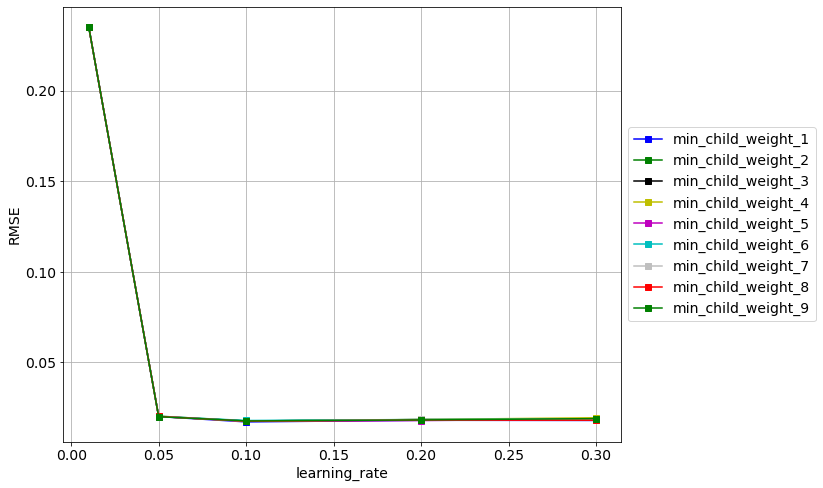

In [61]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [62]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.017
optimum params = 


(0.1, 1)

#### Tuning subsample(default=1) and gamma(default=0)

In [63]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean,  mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-63-d9f5d0e5dbc7>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 1.07


,subsample,gamma,rmse,mae
0,0.1,0.0,0.019206,0.013830
1,0.1,0.1,0.016928,0.011603
2,0.1,0.2,0.016928,0.011603
3,0.1,0.3,0.016928,0.011603
4,0.1,0.4,0.016928,0.011603
...,...,...,...,...
105,1.0,0.6,0.016916,0.011585
106,1.0,0.7,0.016916,0.011585
107,1.0,0.8,0.016916,0.011585
108,1.0,0.9,0.016916,0.011585


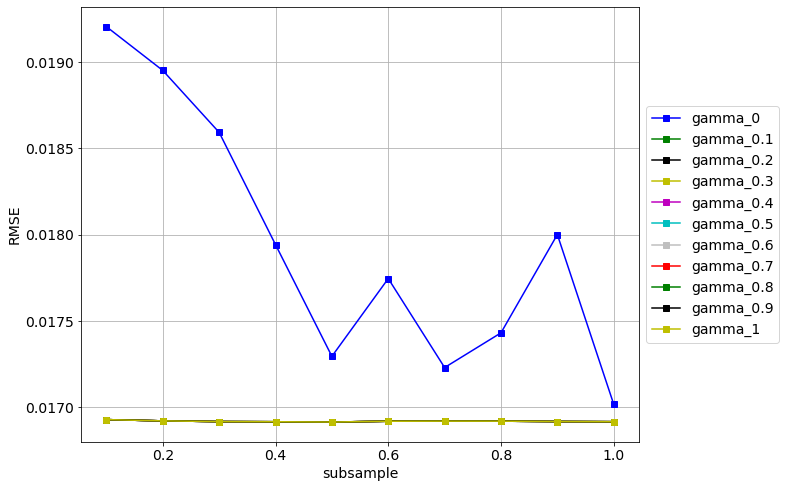

In [64]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [65]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.017
optimum params = 


(0.5, 0.1)

#### Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [66]:
param_label = 'colsample_bytree'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-66-4e70ea290268>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.75


,colsample_bytree,colsample_bylevel,rmse,mae
0,0.1,0.1,0.016914,0.011581
1,0.1,0.2,0.016914,0.011581
2,0.1,0.3,0.016914,0.011581
3,0.1,0.4,0.016914,0.011581
4,0.1,0.5,0.016914,0.011581
...,...,...,...,...
95,1.0,0.6,0.016914,0.011581
96,1.0,0.7,0.016914,0.011581
97,1.0,0.8,0.016914,0.011581
98,1.0,0.9,0.016914,0.011581


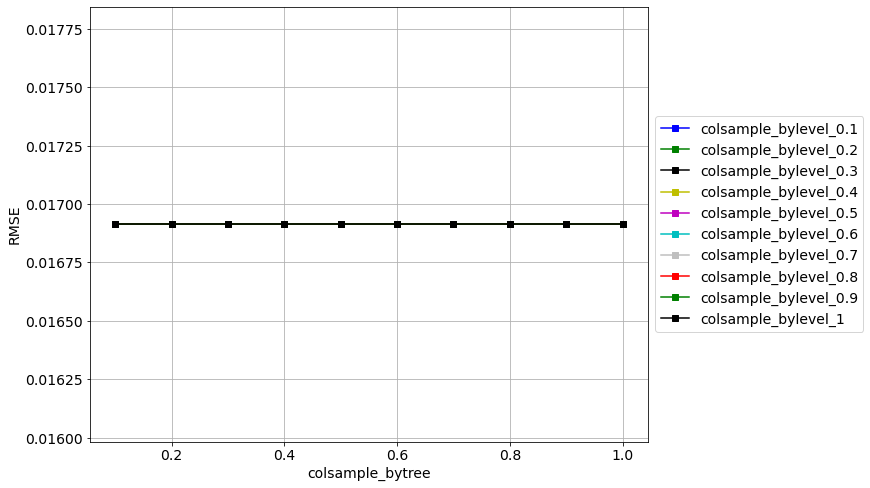

In [67]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [68]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.017
optimum params = 


(0.1, 0.1)

#### Final model

In [69]:
# Get error metrics on validation set after hyperparameter tuning
xgb_rmse_aft_tuning, xgb_mae_aft_tuning, xgb_model_aft_tuning = \
                                                                        xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % xgb_rmse_aft_tuning)
print("MAE = %0.3f" % xgb_mae_aft_tuning)

RMSE = 0.017
MAE = 0.012


#### Tuned params

In [70]:
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0 

In [71]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, xgb_rmse_bef_tuning, xgb_mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, xgb_rmse_aft_tuning, xgb_mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,75.000
1,max_depth,3.000,8.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,1.000
4,subsample,1.000,0.500
5,colsample_bytree,1.000,0.100
6,colsample_bylevel,1.000,0.100
7,gamma,0.000,0.100
8,val_rmse,0.018,0.017
9,val_mae,0.012,0.012


### 3) Prediction after tuning

In [72]:
# Do prediction on test set
xgb_test_rmse_aft_tuning, xgb_test_mae_aft_tuning,xgb_pred = model_test_eval(X_test, y_test,xgb_model_aft_tuning)

print("RMSE = %0.3f" % xgb_test_rmse_aft_tuning)
print("MAE = %0.3f" % xgb_test_mae_aft_tuning)

RMSE = 0.021
MAE = 0.016


In [73]:
# xgb_pred = pd.DataFrame(xgb_pred,columns = ['601390_xgb'])
# xgb_pred.to_excel('D:\海康威视1.xlsx', index = False)

### 4) Importance Analysis

In [ ]:
a =xgb_model_aft_tuning.feature_importances_
a1 = pd.DataFrame(a)
a1.columns = ['importance']
b = X_train.columns
b1 = pd.DataFrame(b)
b1.columns = ['features']
c = pd.concat([b1,a1],axis = 1)
c.sort_values(by= 'importance' , inplace=True, ascending=False) 
c

In [ ]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
# 为了坐标轴负号正常显示。matplotlib默认不支持中文，设置中文字体后，负号会显示异常。需要手动将坐标轴负号设为False才能正常显示负号。
matplotlib.rcParams['axes.unicode_minus'] = False

hkws_top10 = c.head(10)
print(hkws_top10)
imp = pd.DataFrame(np.array(hkws_top10['importance']), index=hkws_top10['features'], columns=['importance'])
imp.plot(kind='barh', figsize=(12, 8))
#hkws_top10.sort_values('importance').plot(kind='barh', figsize=(12, 8))

## 4. Model construction_Random Forest

In [76]:
def rf_model_train_val(X_train, y_train, X_val, y_val,
                          n_estimators=100, 
                          max_depth=3, 
                          min_samples_split=2,
                          min_samples_leaf=1):

    model = RandomForestRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                          min_samples_split=min_samples_split,
                          min_samples_leaf=min_samples_leaf)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE,MAE
    rmse = get_rmse(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mae, model

### 1) Tuning aprameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [81]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = range(55, 70, 2)

param2_label = 'max_depth'
param2_list = range(30,40,1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                            n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-81-0f903179d86f>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 4.10


,n_estimators,max_depth,rmse,mae
0,55,30,0.017648,0.012328
1,55,31,0.017298,0.012157
2,55,32,0.017029,0.011948
3,55,33,0.016950,0.011832
4,55,34,0.016930,0.011952
...,...,...,...,...
75,69,35,0.017336,0.012036
76,69,36,0.017538,0.012501
77,69,37,0.017200,0.012033
78,69,38,0.017274,0.012195


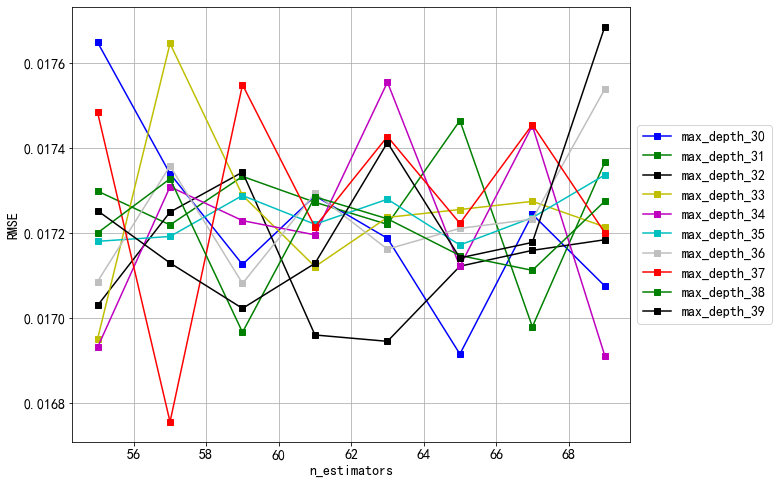

In [82]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [83]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.017
optimum params = 


(57, 37)

#### Tuning min_samples_split(default=2) and  min_samples_leaf(default=1)

In [84]:
from tqdm import tqdm_notebook
param_label = 'min_samples_split'
param_list = range(2, 5)

param2_label = 'min_samples_leaf'
param2_list = range(5,12)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                                    n_estimators=n_estimators_opt,
                                                                     max_depth=max_depth_opt,
                                                                    min_samples_split=param,
                                                                    min_samples_leaf=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-84-7cf10e88798f>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/3 [00:00<?, ?it/s]

Minutes taken = 0.65


,min_samples_split,min_samples_leaf,rmse,mae
0,2,5,0.017058,0.011983
1,2,6,0.017134,0.011901
2,2,7,0.017030,0.011927
3,2,8,0.016829,0.011747
4,2,9,0.017110,0.011989
5,2,10,0.016819,0.011660
6,2,11,0.016911,0.011767
7,3,5,0.017137,0.011946
8,3,6,0.017176,0.011896
9,3,7,0.017172,0.011945


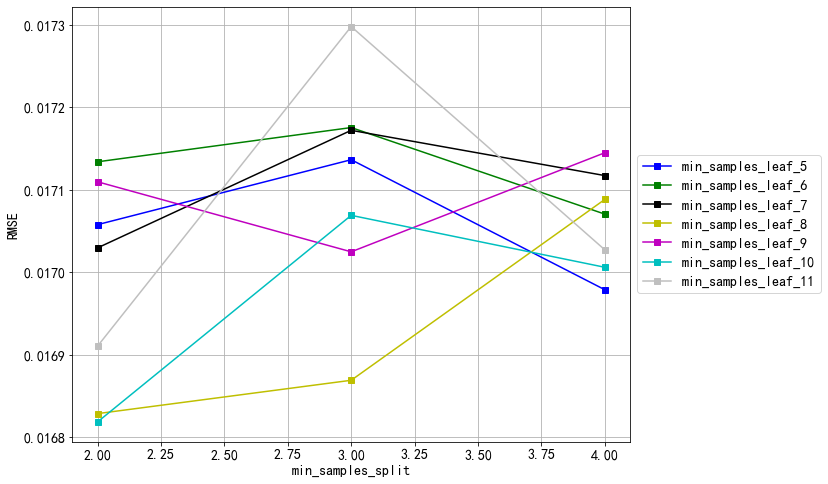

In [85]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [86]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
min_samples_split_opt = temp['min_samples_split'].values[0]
min_samples_leaf_opt = temp['min_samples_leaf'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
min_samples_split_opt, min_samples_leaf_opt

min RMSE = 0.017
optimum params = 


(2, 10)

#### Final Model

In [87]:
# Get error metrics on validation set after hyperparameter tuning
rf_rmse_aft_tuning,rf_mae_aft_tuning, rf_model_aft_tuning = \
                                                                        rf_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,                                                                        
                                                                        min_samples_split=min_samples_split_opt,
                                                                        min_samples_leaf=min_samples_leaf_opt)
print("RMSE = %0.3f" % rf_rmse_aft_tuning)
print("MAE = %0.3f" % rf_mae_aft_tuning)

RMSE = 0.017
MAE = 0.012


In [88]:
# Do prediction on test set
rf_test_rmse_aft_tuning, rf_test_mae_aft_tuning,rf_pred = model_test_eval(X_test, y_test,rf_model_aft_tuning)

print("RMSE = %0.3f" % rf_test_rmse_aft_tuning)
print("MAE = %0.3f" % rf_test_mae_aft_tuning)

RMSE = 0.021
MAE = 0.016


### Importance Analysis

In [91]:
a =rf_model_aft_tuning.feature_importances_
a1 = pd.DataFrame(a)
a1.columns = ['importance']
b = X_train.columns
b1 = pd.DataFrame(b)
b1.columns = ['features']
c = pd.concat([b1,a1],axis = 1)
c.sort_values(by= 'importance' , inplace=True, ascending=False) 
c

,features,importance
2,ret_lag3,0.058873
4,ret_lag5,0.053939
5,ret_lag6,0.046349
3,ret_lag4,0.037920
6,ret_lag7,0.036709
...,...,...
64,宏观_进口价格指数(总)_diff1,0.001674
69,宏观_金融机构各项贷款余额_diff1,0.001624
11,收盘价(元)_diff1,0.001520
70,宏观_社会融资规模_diff1,0.001147


                     features  importance
2                    ret_lag3    0.058873
4                    ret_lag5    0.053939
5                    ret_lag6    0.046349
3                    ret_lag4    0.037920
6                    ret_lag7    0.036709
27              周最高价(元)_diff1    0.032451
55  Industry_市盈率PE(TTM)_diff1    0.030608
8                开盘价(元)_diff1    0.025475
1                    ret_lag2    0.025422
16                均价(元)_diff1    0.025152


<AxesSubplot:ylabel='features'>

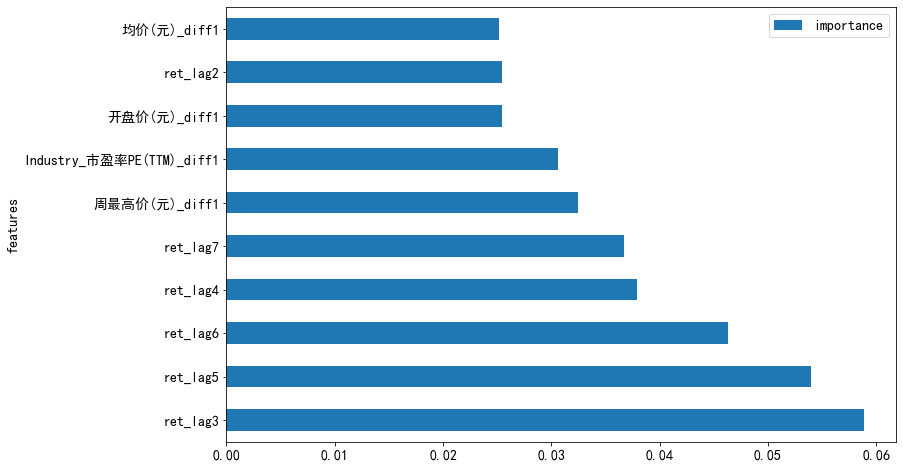

In [92]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
# 为了坐标轴负号正常显示。matplotlib默认不支持中文，设置中文字体后，负号会显示异常。需要手动将坐标轴负号设为False才能正常显示负号。
matplotlib.rcParams['axes.unicode_minus'] = False

hkws_top10 = c.head(10)
print(hkws_top10)
imp = pd.DataFrame(np.array(hkws_top10['importance']), index=hkws_top10['features'], columns=['importance'])
imp.plot(kind='barh', figsize=(12, 8))
#hkws_top10.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
# rf_pred = pd.DataFrame(rf_pred,columns = ['601390_rf'])
# rf_pred.to_excel('D:\海康威视1.xlsx', index = False)

## 5. Model comparison

In [93]:
# Tuned params and before and after error metrics
c = {'XGBOOST_validation': [ xgb_rmse_aft_tuning, xgb_mae_aft_tuning],
     'Random Forest_validation': [rf_rmse_aft_tuning,rf_mae_aft_tuning],
     'XGBOOST_test': [ xgb_test_rmse_aft_tuning,  xgb_test_mae_aft_tuning],
     'Random Forest_test': [rf_test_rmse_aft_tuning, rf_test_mae_aft_tuning],}
comparison = pd.DataFrame(c)
comparison.index = ['RMSE','MAE']
comparison = comparison.round(3)
comparison

,XGBOOST_validation,Random Forest_validation,XGBOOST_test,Random Forest_test
RMSE,0.017,0.017,0.021,0.021
MAE,0.012,0.012,0.016,0.016
